# Validation of optimized results (Full Imput State) from Ligthning Fast One-Shot Side Entanglement

## Imports

In [54]:
import numpy as np
import random
import itertools
import math
import time
import pickle
from typing import Optional, Tuple, cast, List, Dict
from qiskit import Aer, QuantumCircuit, execute, QuantumRegister, ClassicalRegister
from qiskit.result.result import Result

## General auxiliary functions

In [55]:
# Optimization results files to LOAD
filename = '20210419a_C2_A2_1000_100000' # Full input state
#filename = '20210413a_C2_A2_500_10000'  # 2 RX + 2 RY gates
#filename = '20210413a_C2_A3_500_10000'  # 2 RX + 2 RY gates
#filename = '20210414a_C2_A2_500_10000'  # 1 RX + 1 RY gates
#filename = '20210414a_C2_A3_500_10000'  # 1 RX + 1 RY gates

# Validation results files to SAVE
Val_filename = 'GUE_20210419a_C2_A2_1000_100000'  # Full input state
#Val_filename = 'VAL_20210413a_C2_A2_500_10000'  # 2 RX + 2 RY gates
#Val_filename = 'VAL_20210413a_C2_A3_500_10000'  # 2 RX + 2 RY gates
#Val_filename = 'VAL_20210414a_C2_A2_500_10000'  # 1 RX + 1 RY gates
#Val_filename = 'VAL_20210414a_C2_A3_500_10000'  # 1 RX + 1 RY gates

guess_plays = 1000000 # Plays to get the guess
validate_plays = 1000000 # Plays to get the validation

In [56]:
""" save and load results to and from a file """
def save_results_to_disk(obj, name ):
    with open('results/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_results_from_file(name ):
    with open('results/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Auxiliary functions for fast compute the circuit and success average probability

In [57]:
def _run_all_circuits_and_return_guess(configuration: dict,
                                       eta_shots: Optional[Tuple[int, int]] = (1, 1)) -> Tuple[List[int],
                                                                                               List[int]]:
    """ Create a pair of Quantum Circuits, in its transpiled form, from a given configuration """
    if eta_shots is None:
        eta_shots = (1, 1)

    eta_counts = [cast(Result, execute(_create_one_circuit(configuration, eta),
                                         backend=GLOBAL_BACKEND,
                                         shots=eta_shots[idx],
                                         memory=False).result()).get_counts()
                    for idx, eta in enumerate(configuration['eta_pair'])]
    counts0_distribution = [-1.0, -1.0, -1.0, -1.0]
    counts1_distribution = [-1.0, -1.0, -1.0, -1.0]
    counts_distribution =  [0.0, 0.0, 0.0, 0.0]
    guess = [2, 2, 2, 2]
    if '00' in eta_counts[0]: 
        counts0_distribution[0]= eta_counts[0]['00']/(2*eta_shots[0])
    if '01' in eta_counts[0]: 
        counts0_distribution[1]= eta_counts[0]['01']/(2*eta_shots[0])
    if '10' in eta_counts[0]: 
        counts0_distribution[2]= eta_counts[0]['10']/(2*eta_shots[0])
    if '11' in eta_counts[0]: 
        counts0_distribution[3]= eta_counts[0]['11']/(2*eta_shots[0])
    if '00' in eta_counts[1]: 
        counts1_distribution[0]= eta_counts[1]['00']/(2*eta_shots[0])
    if '01' in eta_counts[1]: 
        counts1_distribution[1]= eta_counts[1]['01']/(2*eta_shots[0])
    if '10' in eta_counts[1]: 
        counts1_distribution[2]= eta_counts[1]['10']/(2*eta_shots[0])
    if '11' in eta_counts[1]: 
        counts1_distribution[3]= eta_counts[1]['11']/(2*eta_shots[0])
    for i in range(len(guess)):
        counts_distribution[i] = max (counts_distribution[i], counts0_distribution[i], counts1_distribution[i])
        if counts_distribution[i] == counts0_distribution[i]:
            guess[i] = 0
        elif counts_distribution[i] == counts1_distribution[i]:
            guess[i] = 1
    return counts_distribution, guess

In [58]:
def _run_all_circuits_and_validate_guess(configuration: dict,
                                       eta_shots: Optional[Tuple[int, int]] = (1, 1), guess: Optional[List[int]]=[0,0,0,0]) -> Tuple[List[int],
                                                                                               List[int]]:
    """ Create a pair of Quantum Circuits, in its transpiled form, from a given configuration """
    if eta_shots is None:
        eta_shots = (1, 1)

    eta_counts = [cast(Result, execute(_create_one_circuit(configuration, eta),
                                         backend=GLOBAL_BACKEND,
                                         shots=eta_shots[idx],
                                         memory=False).result()).get_counts()
                    for idx, eta in enumerate(configuration['eta_pair'])]
    probs_distribution = [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
    final_distribution = [0.0, 0.0, 0.0, 0.0]
    if '00' in eta_counts[0]: 
        probs_distribution[0][0]= eta_counts[0]['00']/(2*eta_shots[0])
    if '01' in eta_counts[0]: 
        probs_distribution[0][1]= eta_counts[0]['01']/(2*eta_shots[0])
    if '10' in eta_counts[0]: 
        probs_distribution[0][2]= eta_counts[0]['10']/(2*eta_shots[0])
    if '11' in eta_counts[0]: 
        probs_distribution[0][3]= eta_counts[0]['11']/(2*eta_shots[0])
    if '00' in eta_counts[1]: 
        probs_distribution[1][0]= eta_counts[1]['00']/(2*eta_shots[0])
    if '01' in eta_counts[1]: 
        probs_distribution[1][1]= eta_counts[1]['01']/(2*eta_shots[0])
    if '10' in eta_counts[1]: 
        probs_distribution[1][2]= eta_counts[1]['10']/(2*eta_shots[0])
    if '11' in eta_counts[1]: 
        probs_distribution[1][3]= eta_counts[1]['11']/(2*eta_shots[0])
    for i in range(len(guess)):
        if guess[i] == 2:    # if guess has value = 2 this state didn't appeared so we count 50% each
            final_distribution[i] = (probs_distribution[0][i]+probs_distribution[1][i])/2
        else:
            final_distribution[i] = probs_distribution[guess[i]][i]
    #print(final_distribution)
    return final_distribution, guess

In [59]:
def _create_one_circuit(configuration: dict,
                        eta: float) -> QuantumCircuit:
    """ Creates one circuit from a given configuration and eta """
    qreg_q = QuantumRegister(3, 'q')
    creg_c = ClassicalRegister(2, 'c')

    #initial_state = _prepare_initial_state_entangled(configuration['state_probability'])

    circuit = QuantumCircuit(qreg_q, creg_c)
    #circuit.initialize(initial_state, [0, 1])
    circuit.reset(qreg_q)
    circuit.rx(configuration['angle_In_rx1'], qreg_q[1])
    circuit.ry(configuration['angle_In_ry1'], qreg_q[1])
    circuit.rx(configuration['angle_In_rx0'], qreg_q[0])
    circuit.ry(configuration['angle_In_ry0'], qreg_q[0])
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.cry(2 * eta, qreg_q[1], qreg_q[2])
    circuit.cx(qreg_q[2], qreg_q[1])
    circuit.barrier()
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.h(qreg_q[0])
    circuit.rx(configuration['angle_Out_rx1'], qreg_q[1])
    circuit.ry(configuration['angle_Out_ry1'], qreg_q[1])
    circuit.rx(configuration['angle_Out_rx0'], qreg_q[0])
    circuit.ry(configuration['angle_Out_ry0'], qreg_q[0])
    circuit.measure([0, 1], creg_c)
    return circuit

In [60]:
#def _prepare_initial_state_entangled(state_probability: float) -> Tuple[complex, complex, complex, complex]:
#    """ Prepare initial state: computing 'y' as the amplitudes  """
#    # ORIGINAL
#    return (0, np.sqrt(state_probability), np.sqrt(1 - state_probability), 0)
#    # return (0, np.sqrt(1 - state_probability), np.sqrt(state_probability), 0)

## Get optimized configuration to define the guess

In [61]:
optzed_results = load_results_from_file(name=filename)
GLOBAL_BACKEND=Aer.get_backend('qasm_simulator')
GLOBAL_ETA_PAIRS = optzed_results['eta_pairs']
POVM_configurations = optzed_results['configurations']
guess_list = []
probs_validation_list = []
validated_results = optzed_results
program_start_time = time.time()
for i in range(len(GLOBAL_ETA_PAIRS)):
    start_time = time.time()
    counts_distribution, guess = _run_all_circuits_and_return_guess(POVM_configurations[i],[guess_plays, guess_plays])
    expected_prob = counts_distribution[0]+counts_distribution[1]+counts_distribution[2]+counts_distribution[3]
    #print('The expected probability to distinguish this eta pair is: ' + str(optzed_results['probabilities'][i]) + ' now: '+ str(expected_prob))
    #print('The guess to implement will do the following selections:')
    #print('   00 counts goes to: eta' + str(guess[0]) + ' which adds this probability: ' + str(counts_distribution[0]))
    #print('   10 counts goes to: eta' + str(guess[1]) + ' which adds this probability: ' + str(counts_distribution[1]))
    #print('   01 counts goes to: eta' + str(guess[2]) + ' which adds this probability: ' + str(counts_distribution[2]))
    #print('   11 counts goes to: eta' + str(guess[3]) + ' which adds this probability: ' + str(counts_distribution[3]))
    probs_validation, guess_v = _run_all_circuits_and_validate_guess(POVM_configurations[i],[validate_plays, validate_plays], guess)

    validated_results['probabilities'][i] = probs_validation[0] + probs_validation[1] + probs_validation[2] + probs_validation[3]
    guess_list.append(guess)
    probs_validation_list.append(probs_validation)
    
    end_time = time.time()
    print(f"Pair of etas # {i+1} of {len(GLOBAL_ETA_PAIRS)}, time taken this pair of etas: " +
              f'{np.round((end_time - start_time)/60, 0)} minutes' +
              f' and {np.round((end_time - start_time) % 60, 0)} seconds')
    print("total minutes taken this pair of etas: ", int(np.round((end_time - start_time) / 60)))
    print("total time taken so far: " +
              f'{np.round((end_time - program_start_time)/60, 0)} minutes' +
              f' and {np.round((end_time - program_start_time) % 60, 0)} seconds')
end_time = time.time()
    
validated_results['guess'] = guess_list
validated_results['indiv_prob'] = probs_validation_list


Pair of etas # 1 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 0.0 minutes and 5.0 seconds
Pair of etas # 2 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 0.0 minutes and 9.0 seconds
Pair of etas # 3 of 210, time taken this pair of etas: 0.0 minutes and 4.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 0.0 minutes and 14.0 seconds
Pair of etas # 4 of 210, time taken this pair of etas: 0.0 minutes and 4.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 0.0 minutes and 18.0 seconds
Pair of etas # 5 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 0.0 minutes and 23.0 seconds
Pair of etas # 6 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this

Pair of etas # 47 of 210, time taken this pair of etas: 0.0 minutes and 4.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 4.0 minutes and 40.0 seconds
Pair of etas # 48 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 4.0 minutes and 45.0 seconds
Pair of etas # 49 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 4.0 minutes and 50.0 seconds
Pair of etas # 50 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 4.0 minutes and 55.0 seconds
Pair of etas # 51 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 4.0 minutes and 59.0 seconds
Pair of etas # 52 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes ta

Pair of etas # 93 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 7.0 minutes and 25.0 seconds
Pair of etas # 94 of 210, time taken this pair of etas: 0.0 minutes and 4.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 7.0 minutes and 29.0 seconds
Pair of etas # 95 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 8.0 minutes and 34.0 seconds
Pair of etas # 96 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 8.0 minutes and 39.0 seconds
Pair of etas # 97 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 8.0 minutes and 44.0 seconds
Pair of etas # 98 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes ta

Pair of etas # 139 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 11.0 minutes and 11.0 seconds
Pair of etas # 140 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 11.0 minutes and 16.0 seconds
Pair of etas # 141 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 11.0 minutes and 21.0 seconds
Pair of etas # 142 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 11.0 minutes and 26.0 seconds
Pair of etas # 143 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 12.0 minutes and 31.0 seconds
Pair of etas # 144 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total

Pair of etas # 185 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 15.0 minutes and 59.0 seconds
Pair of etas # 186 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 15.0 minutes and 4.0 seconds
Pair of etas # 187 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 15.0 minutes and 9.0 seconds
Pair of etas # 188 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 15.0 minutes and 14.0 seconds
Pair of etas # 189 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  0
total time taken so far: 15.0 minutes and 19.0 seconds
Pair of etas # 190 of 210, time taken this pair of etas: 0.0 minutes and 5.0 seconds
total m

In [62]:
save_results_to_disk(validated_results, Val_filename)

In [63]:
validated_results

{'eta_pairs': [(0.07853981633974483, 0.0),
  (0.15707963267948966, 0.0),
  (0.23561944901923448, 0.0),
  (0.3141592653589793, 0.0),
  (0.39269908169872414, 0.0),
  (0.47123889803846897, 0.0),
  (0.5497787143782138, 0.0),
  (0.6283185307179586, 0.0),
  (0.7068583470577035, 0.0),
  (0.7853981633974483, 0.0),
  (0.8639379797371931, 0.0),
  (0.9424777960769379, 0.0),
  (1.0210176124166828, 0.0),
  (1.0995574287564276, 0.0),
  (1.1780972450961724, 0.0),
  (1.2566370614359172, 0.0),
  (1.335176877775662, 0.0),
  (1.413716694115407, 0.0),
  (1.4922565104551517, 0.0),
  (1.5707963267948966, 0.0),
  (0.15707963267948966, 0.07853981633974483),
  (0.23561944901923448, 0.07853981633974483),
  (0.3141592653589793, 0.07853981633974483),
  (0.39269908169872414, 0.07853981633974483),
  (0.47123889803846897, 0.07853981633974483),
  (0.5497787143782138, 0.07853981633974483),
  (0.6283185307179586, 0.07853981633974483),
  (0.7068583470577035, 0.07853981633974483),
  (0.7853981633974483, 0.078539816339744

{'eta_pairs': [(0.07853981633974483, 0.0),
  (0.15707963267948966, 0.0),
  (0.23561944901923448, 0.0),
  (0.3141592653589793, 0.0),
  (0.39269908169872414, 0.0),
  (0.47123889803846897, 0.0),
  (0.5497787143782138, 0.0),
  (0.6283185307179586, 0.0),
  (0.7068583470577035, 0.0),
  (0.7853981633974483, 0.0),
  (0.8639379797371931, 0.0),
  (0.9424777960769379, 0.0),
  (1.0210176124166828, 0.0),
  (1.0995574287564276, 0.0),
  (1.1780972450961724, 0.0),
  (1.2566370614359172, 0.0),
  (1.335176877775662, 0.0),
  (1.413716694115407, 0.0),
  (1.4922565104551517, 0.0),
  (1.5707963267948966, 0.0),
  (0.15707963267948966, 0.07853981633974483),
  (0.23561944901923448, 0.07853981633974483),
  (0.3141592653589793, 0.07853981633974483),
  (0.39269908169872414, 0.07853981633974483),
  (0.47123889803846897, 0.07853981633974483),
  (0.5497787143782138, 0.07853981633974483),
  (0.6283185307179586, 0.07853981633974483),
  (0.7068583470577035, 0.07853981633974483),
  (0.7853981633974483, 0.078539816339744

{'eta_pairs': [(0.07853981633974483, 0.0),
  (0.15707963267948966, 0.0),
  (0.23561944901923448, 0.0),
  (0.3141592653589793, 0.0),
  (0.39269908169872414, 0.0),
  (0.47123889803846897, 0.0),
  (0.5497787143782138, 0.0),
  (0.6283185307179586, 0.0),
  (0.7068583470577035, 0.0),
  (0.7853981633974483, 0.0),
  (0.8639379797371931, 0.0),
  (0.9424777960769379, 0.0),
  (1.0210176124166828, 0.0),
  (1.0995574287564276, 0.0),
  (1.1780972450961724, 0.0),
  (1.2566370614359172, 0.0),
  (1.335176877775662, 0.0),
  (1.413716694115407, 0.0),
  (1.4922565104551517, 0.0),
  (1.5707963267948966, 0.0),
  (0.15707963267948966, 0.07853981633974483),
  (0.23561944901923448, 0.07853981633974483),
  (0.3141592653589793, 0.07853981633974483),
  (0.39269908169872414, 0.07853981633974483),
  (0.47123889803846897, 0.07853981633974483),
  (0.5497787143782138, 0.07853981633974483),
  (0.6283185307179586, 0.07853981633974483),
  (0.7068583470577035, 0.07853981633974483),
  (0.7853981633974483, 0.078539816339744

In [66]:
# results

In [67]:
#qreg_q = QuantumRegister(3, 'q')
#creg_c = ClassicalRegister(2, 'c')
#circuit = QuantumCircuit(qreg_q, creg_c)
#circuit.initialize([0,1,0,0], [0, 1])
#circuit.reset(qreg_q[2])
#circuit.cry(0, qreg_q[1], qreg_q[2])
#circuit.cx(qreg_q[2], qreg_q[1])
#circuit.barrier()
#circuit.rx(0, qreg_q[1])
#circuit.ry(0, qreg_q[1])
#circuit.rx(0, qreg_q[0])
#circuit.ry(0, qreg_q[0])
#circuit.cx(qreg_q[0], qreg_q[1])
#circuit.h(qreg_q[0])
#circuit.measure([0, 1], creg_c)
#circuit.draw()

Text(0.5, 1.0, 'stacked probabilities')

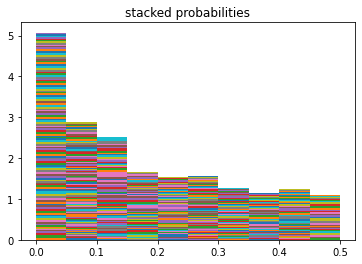

In [75]:
import matplotlib
matplotlib.axes.Axes.hist
matplotlib.pyplot.hist
import matplotlib.pyplot as plt

colors = ['red', 'tan', 'blue', 'green']
states = ['00', '01', '10', '11']
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist(probs_validation_list, density=True, histtype='bar', stacked=True, label=states)
ax.set_title('stacked probabilities')

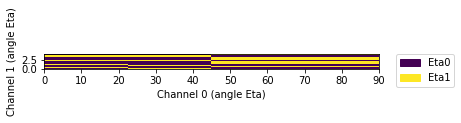

In [82]:
import matplotlib.patches as mpatches
fig = plt.figure('Optimization algorithm contribution in simulation')
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Channel 0 (angle Eta)')
ax1.set_ylabel('Channel 1 (angle Eta)')

values = [0, 1]
Opt = ['Eta0', 'Eta1']
im = plt.imshow(guess_list, interpolation='none', extent =(0, 90, 0, 4))
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=Opt[i]) for i in range(len(Opt)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.grid(False)


plt.show()